## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from graphnet.data.constants import FEATURES, TRUTH

from icecube_utils import (
    load_pretrained_model,
    inference, 
)
from wasserstein_ensemble import get_histogram, _get_neuron_importance_histogram, update_model
from parameters import get_parser
from train_large import config as config_large

features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

graphnet: INFO     2023-03-01 12:08:05 - get_logger - Writing log to logs/graphnet_20230301-120805.log


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet: WARNING  2023-03-01 12:08:12 - warn_once - `icecube` not available. Some functionality may be missing.


In [4]:
from collections import OrderedDict
import ot
import torch
import numpy as np
from ground_metric import GroundMetric

def get_wassersteinized_layers_modularized(args, networks, T_vars_pre_computed=None, activations=None, eps=1e-7, test_loader=None):
    '''
    Two neural networks that have to be averaged in geometric manner (i.e. layerwise).
    The 1st network is aligned with respect to the other via wasserstein distance.
    Also this assumes that all the layers are either fully connected or convolutional *(with no bias)*

    :param networks: list of networks
    :param activations: If not None, use it to build the activation histograms.
    Otherwise assumes uniform distribution over neurons in a layer.
    :return: list of layer weights 'wassersteinized', list of transport maps
    '''

    # simple_model_0, simple_model_1 = networks[0], networks[1]
    # simple_model_0 = get_trained_model(0, model='simplenet')
    # simple_model_1 = get_trained_model(1, model='simplenet')

    avg_aligned_layers, aligned_layers, T_vars = [], OrderedDict(), []
    # cumulative_T_var = None
    T_var = None
    # print(list(networks[0].parameters()))
    previous_layer_shape = None
    ground_metric_object = GroundMetric(args)

    if args.eval_aligned:
        model0_aligned_layers = []

    if args.gpu_id==-1:
        device = torch.device('cpu')
    else:
        device = torch.device('cuda:{}'.format(args.gpu_id))

    network0_named_parameters = networks[0].named_parameters()
    network1_named_parameters = networks[1].named_parameters()

    num_layers = len(list(zip(networks[0].parameters(), networks[1].parameters())))
    for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
            enumerate(zip(network0_named_parameters, network1_named_parameters)):

        # assert fc_layer0_weight.shape == fc_layer1_weight.shape
        print("Previous layer shape is ", previous_layer_shape)
        previous_layer_shape = fc_layer1_weight.shape

        mu_cardinality = fc_layer0_weight.shape[0]
        nu_cardinality = fc_layer1_weight.shape[0]

        # mu = np.ones(fc_layer0_weight.shape[0])/fc_layer0_weight.shape[0]
        # nu = np.ones(fc_layer1_weight.shape[0])/fc_layer1_weight.shape[0]

        layer_shape = fc_layer0_weight.shape
        if len(layer_shape) > 2:
            is_conv = True
            # For convolutional layers, it is (#out_channels, #in_channels, height, width)
            fc_layer0_weight_data = fc_layer0_weight.data.view(fc_layer0_weight.shape[0], fc_layer0_weight.shape[1], -1)
            fc_layer1_weight_data = fc_layer1_weight.data.view(fc_layer1_weight.shape[0], fc_layer1_weight.shape[1], -1)
        else:
            is_conv = False
            if len(layer_shape) < 2:  # bias
                fc_layer0_weight_data = fc_layer0_weight.data[None, :]
                fc_layer1_weight_data = fc_layer1_weight.data[None, :]
                # fc_layer0_weight_data = fc_layer0_weight.data[:, None]
                # fc_layer1_weight_data = fc_layer1_weight.data[:, None]
            else:
                fc_layer0_weight_data = fc_layer0_weight.data
                fc_layer1_weight_data = fc_layer1_weight.data

        print(f'Layer {layer0_name, layer1_name} shape is {fc_layer0_weight_data.shape} and {fc_layer1_weight_data.shape}')

        if idx == 0:
            if is_conv:
                M = ground_metric_object.process(fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1),
                                fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
                # M = cost_matrix(fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1),
                #                 fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
            else:
                # print("layer data is ", fc_layer0_weight_data, fc_layer1_weight_data)
                M = ground_metric_object.process(fc_layer0_weight_data, fc_layer1_weight_data)
                # M = cost_matrix(fc_layer0_weight, fc_layer1_weight)

            aligned_wt = fc_layer0_weight_data
        else:

            print("shape of layer: model 0", fc_layer0_weight_data.shape)
            print("shape of layer: model 1", fc_layer1_weight_data.shape)
            print("shape of previous transport map", T_var.shape)

            # aligned_wt = None, this caches the tensor and causes OOM
            if is_conv:
                T_var_conv = T_var.unsqueeze(0).repeat(fc_layer0_weight_data.shape[2], 1, 1)
                aligned_wt = torch.bmm(fc_layer0_weight_data.permute(2, 0, 1), T_var_conv).permute(1, 2, 0)

                M = ground_metric_object.process(
                    aligned_wt.contiguous().view(aligned_wt.shape[0], -1),
                    fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1)
                )
            else:
                print(f'fc_layer0_weight_data.shape = {fc_layer0_weight_data.shape}')
                print(f'T_var.shape = {T_var.shape}')
                if '_post_processing.0' in layer0_name and 'weight' in layer0_name:
                    T_var = torch.block_diag(*[val for name, val in T_vars if 'nn.2.weight' in name])
                    print(f'T_var.shape = {T_var.shape}')
                    aligned_wt = torch.cat([
                        fc_layer0_weight_data[:, :17],
                        torch.matmul(fc_layer0_weight_data[:, 17:], T_var)
                    ], dim=1)
                elif 'bias' in layer0_name:
                    aligned_wt = torch.matmul(fc_layer0_weight_data, T_var).t()
                elif fc_layer0_weight_data.shape[1] != T_var.shape[0]:
                    print(fc_layer0_weight_data.shape, T_var.shape)
                    # Handles the switch from convolutional layers to fc layers
                    fc_layer0_unflattened = fc_layer0_weight_data.view(fc_layer0_weight.shape[0], T_var.shape[0], -1).permute(2, 0, 1)
                    aligned_wt = torch.bmm(
                        fc_layer0_unflattened,
                        T_var.unsqueeze(0).repeat(fc_layer0_unflattened.shape[0], 1, 1)
                    ).permute(1, 2, 0)
                    aligned_wt = aligned_wt.contiguous().view(aligned_wt.shape[0], -1)
                
                else:
                    # print("layer data (aligned) is ", aligned_wt, fc_layer1_weight_data)
                    aligned_wt = torch.matmul(fc_layer0_weight_data, T_var)
                print(f'aligned_wt shape is {aligned_wt.shape}')
                print(f'fc_layer1_weight_data shape is {fc_layer1_weight_data.shape}')
                # M = cost_matrix(aligned_wt, fc_layer1_weight)
                M = ground_metric_object.process(aligned_wt, fc_layer1_weight_data)
                print("ground metric is ", M)
            if args.skip_last_layer and idx == (num_layers - 1):
                print("Simple averaging of last layer weights. NO transport map needs to be computed")
                if args.ensemble_step != 0.5:
                    avg_aligned_layers.append((1 - args.ensemble_step) * aligned_wt +
                                          args.ensemble_step * fc_layer1_weight)
                else:
                    avg_aligned_layers.append((aligned_wt + fc_layer1_weight)/2)
                T_vars.append((layer0_name, torch.diag(torch.ones(fc_layer1_weight.shape[1]))))
                aligned_layers[layer0_name] = aligned_wt
                return avg_aligned_layers

        if args.importance is None or (idx == num_layers -1):
            mu = get_histogram(args, 0, mu_cardinality, layer0_name)
            nu = get_histogram(args, 1, nu_cardinality, layer1_name)
        else:
            # mu = _get_neuron_importance_histogram(args, aligned_wt, is_conv)
            mu = _get_neuron_importance_histogram(args, fc_layer0_weight_data, is_conv)
            nu = _get_neuron_importance_histogram(args, fc_layer1_weight_data, is_conv)
            print(mu, nu)
            assert args.proper_marginals

        if 'bias' in layer0_name:
            pass
        elif T_vars_pre_computed is None:
            cpuM = M.data.cpu().numpy()
            print(f'mu shape is {mu.shape}')
            print(f'nu shape is {nu.shape}')
            print(f'cpuM shape is {cpuM.shape}')
            if args.exact:
                T = ot.emd(mu, nu, cpuM)
            else:
                T = ot.bregman.sinkhorn(mu, nu, cpuM, reg=args.reg)
            # T = ot.emd(mu, nu, log_cpuM)

            if args.gpu_id!=-1:
                T_var = torch.from_numpy(T).cuda(args.gpu_id).float()
            else:
                T_var = torch.from_numpy(T).float()

            # torch.set_printoptions(profile="full")
            print("the transport map is ", T_var)
            # torch.set_printoptions(profile="default")

            if args.correction:
                if not args.proper_marginals:
                    # think of it as m x 1, scaling weights for m linear combinations of points in X
                    if args.gpu_id != -1:
                        # marginals = torch.mv(T_var.t(), torch.ones(T_var.shape[0]).cuda(args.gpu_id))  # T.t().shape[1] = T.shape[0]
                        marginals = torch.ones(T_var.shape[0]).cuda(args.gpu_id) / T_var.shape[0]
                    else:
                        # marginals = torch.mv(T_var.t(),
                        #                      torch.ones(T_var.shape[0]))  # T.t().shape[1] = T.shape[0]
                        marginals = torch.ones(T_var.shape[0]) / T_var.shape[0]
                    marginals = torch.diag(1.0/(marginals + eps))  # take inverse
                    T_var = torch.matmul(T_var, marginals)
                else:
                    # marginals_alpha = T_var @ torch.ones(T_var.shape[1], dtype=T_var.dtype).to(device)
                    marginals_beta = T_var.t() @ torch.ones(T_var.shape[0], dtype=T_var.dtype).to(device)

                    marginals = (1 / (marginals_beta + eps))
                    print("shape of inverse marginals beta is ", marginals_beta.shape)
                    print("inverse marginals beta is ", marginals_beta)

                    T_var = T_var * marginals
                    # i.e., how a neuron of 2nd model is constituted by the neurons of 1st model
                    # this should all be ones, and number equal to number of neurons in 2nd model
                    print(T_var.sum(dim=0))
                    # assert (T_var.sum(dim=0) == torch.ones(T_var.shape[1], dtype=T_var.dtype).to(device)).all()
        else:
            T_var = T_vars_pre_computed[idx]
        
        if args.debug:
            if idx == (num_layers - 1):
                print("there goes the last transport map: \n ", T_var)
            else:
                print("there goes the transport map at layer {}: \n ".format(idx), T_var)

            print("Ratio of trace to the matrix sum: ", torch.trace(T_var) / torch.sum(T_var))

        print("Ratio of trace to the matrix sum: ", torch.trace(T_var) / torch.sum(T_var))
        print("Here, trace is {} and matrix sum is {} ".format(torch.trace(T_var), torch.sum(T_var)))
        setattr(args, 'trace_sum_ratio_{}'.format(layer0_name), (torch.trace(T_var) / torch.sum(T_var)).item())

        if args.past_correction:
            print("this is past correction for weight mode")
            print("Shape of aligned wt is ", aligned_wt.shape)
            print("Shape of fc_layer0_weight_data is ", fc_layer0_weight_data.shape)
            if 'bias' in layer0_name:
                # here, no need to align so as T_var is not changed
                t_fc0_model = aligned_wt
            else:
                t_fc0_model = torch.matmul(T_var.t(), aligned_wt.contiguous().view(aligned_wt.shape[0], -1))
        else:
            t_fc0_model = torch.matmul(T_var.t(), fc_layer0_weight_data.view(fc_layer0_weight_data.shape[0], -1))

        # Average the weights of aligned first layers
        if args.ensemble_step != 0.5:
            geometric_fc = ((1-args.ensemble_step) * t_fc0_model +
                            args.ensemble_step * fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))
        else:
            geometric_fc = (t_fc0_model + fc_layer1_weight_data.view(fc_layer1_weight_data.shape[0], -1))/2
        if is_conv and layer_shape != geometric_fc.shape:
            geometric_fc = geometric_fc.view(layer_shape)
        avg_aligned_layers.append(geometric_fc)
        aligned_layers[layer0_name] = t_fc0_model
        T_vars.append((layer0_name, T_var))

        # get the performance of the model 0 aligned with respect to the model 1
        if args.eval_aligned:
            if is_conv and layer_shape != t_fc0_model.shape:
                t_fc0_model = t_fc0_model.view(layer_shape)
            model0_aligned_layers.append(t_fc0_model)
            _, acc = update_model(args, networks[0], model0_aligned_layers, test=True,
                                  test_loader=test_loader, idx=0)
            print("For layer idx {}, accuracy of the updated model is {}".format(idx, acc))
            setattr(args, 'model0_aligned_acc_layer_{}'.format(str(idx)), acc)
            if idx == (num_layers - 1):
                setattr(args, 'model0_aligned_acc', acc)

    return avg_aligned_layers, aligned_layers, T_vars

In [5]:
# Configuration
config_small = {
        "path": '/workspace/icecube/data/batch_1.db',
        "inference_database_path": '/workspace/icecube/data/batch_51.db',
        "pulsemap": 'pulse_table',
        "truth_table": 'meta_table',
        "features": features,
        "truth": truth,
        "index_column": 'event_id',
        "run_name_tag": 'my_example',
        "batch_size": 200,
        "num_workers": 8,
        "target": 'direction',
        "early_stopping_patience": 5,
        "fit": {
                "max_epochs": 50,
                'max_steps': 0,
                "gpus": [0],
                "distribution_strategy": None,
                },
        'train_selection': '/workspace/icecube/data/train_selection_max_200_pulses.csv',
        'validate_selection': '/workspace/icecube/data/validate_selection_max_200_pulses.csv',
        'test_selection': None,
        'base_dir': 'training',
        'dynedge': {}
}

In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [6]:
model_small = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_batch_1_to_50/state_dict.pth')

In [7]:
model_large = load_pretrained_model(config=config_large, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_large/state_dict.pth')

In [8]:
model_small

StandardModel(
  (_detector): IceCubeKaggle(
    (_graph_builder): KNNGraphBuilder()
  )
  (_gnn): DynEdge(
    (_activation): LeakyReLU(negative_slope=0.01)
    (_conv_layers): ModuleList(
      (0): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=34, out_features=128, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (1): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (2): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=512, out_features=336, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=336, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (3):

In [9]:
model_large

StandardModel(
  (_detector): IceCubeKaggle(
    (_graph_builder): KNNGraphBuilder()
  )
  (_gnn): DynEdge(
    (_activation): LeakyReLU(negative_slope=0.01)
    (_conv_layers): ModuleList(
      (0): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=34, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=256, out_features=512, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (1): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=1024, out_features=672, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=672, out_features=512, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (2): DynEdgeConv(nn=Sequential(
        (0): Linear(in_features=1024, out_features=672, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=672, out_features=512, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
      ))
      (3

In [10]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = False

In [11]:
_, model_large_mapped_state_dict, _ = get_wassersteinized_layers_modularized(args, [model_small.cuda(), model_large.cuda()])
model_large_mapped_state_dict = {
    k: v if not 'bias' in k else v[:, 0] 
    for k, v in model_large_mapped_state_dict.items()
}

Previous layer shape is  None
Layer ('_gnn._conv_layers.0.nn.0.weight', '_gnn._conv_layers.0.nn.0.weight') shape is torch.Size([128, 34]) and torch.Size([256, 34])
Processing the coordinates to form ground_metric
dont leave off the squaring of the ground metric
returns a uniform measure of cardinality:  128
returns a uniform measure of cardinality:  256
mu shape is (128,)
nu shape is (256,)
cpuM shape is (128, 256)
the transport map is  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
shape of inverse marginals beta is  torch.Size([256])
inverse marginals beta is  tensor([0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 

In [12]:
model_large_mapped_state_dict

{'_gnn._conv_layers.0.nn.0.weight': tensor([[ 0.0332, -0.0824, -0.0883,  ..., -0.0690,  0.1500, -0.0187],
         [-0.0218, -0.0412, -0.0847,  ..., -0.0582,  0.0275,  0.0800],
         [-0.0923, -0.2520, -0.0319,  ..., -0.0799,  0.1501, -0.1278],
         ...,
         [ 0.0184, -0.0025,  0.0227,  ..., -0.1167,  0.1622,  0.0630],
         [ 0.0160,  0.0439,  0.0154,  ..., -0.1215, -0.0129, -0.0198],
         [-0.0344,  0.0107, -0.0051,  ...,  0.0452, -0.1165, -0.1032]],
        device='cuda:0'),
 '_gnn._conv_layers.0.nn.0.bias': tensor([ 0.0972, -0.0143, -0.0563,  0.1735, -0.1152, -0.0431, -0.0147,  0.1131,
         -0.0279, -0.2034, -0.0861,  0.0259, -0.0841,  0.1089, -0.2077, -0.0246,
         -0.0415, -0.1971,  0.0082, -0.0222,  0.0365,  0.0777, -0.1152, -0.2722,
          0.0303, -0.2197,  0.0287,  0.1358,  0.1201,  0.1457, -0.1649,  0.0323,
          0.0815,  0.0145, -0.0563,  0.0736,  0.0364, -0.0438, -0.2197,  0.1086,
         -0.0463, -0.1232, -0.2537, -0.1211,  0.1016,  0.048

In [13]:
model_large.state_dict()

OrderedDict([('_gnn._conv_layers.0.nn.0.weight',
              tensor([[-0.0590,  0.0250, -0.0824,  ...,  0.0752,  0.1129,  0.0989],
                      [ 0.1492, -0.0458, -0.1469,  ...,  0.0652,  0.0014,  0.1690],
                      [-0.1397, -0.0107,  0.0575,  ..., -0.0207, -0.0671, -0.0339],
                      ...,
                      [ 0.0143,  0.0851,  0.0321,  ...,  0.1410,  0.1231, -0.0308],
                      [ 0.0979,  0.0097,  0.1237,  ..., -0.0466,  0.0295, -0.0333],
                      [-0.0362,  0.1529, -0.1175,  ...,  0.1245,  0.0384, -0.0468]],
                     device='cuda:0')),
             ('_gnn._conv_layers.0.nn.0.bias',
              tensor([ 0.1443,  0.0476,  0.1328,  0.1072, -0.0953, -0.0385,  0.0445,  0.0620,
                       0.0998,  0.0543,  0.0197, -0.0371,  0.1526,  0.0691,  0.1502, -0.1699,
                      -0.1003,  0.1492,  0.1033, -0.1461, -0.1065,  0.0933, -0.0070, -0.0206,
                      -0.1021,  0.0419, -0.0666,  

In [14]:
model_large_mapped = deepcopy(model_large)
model_large_mapped.load_state_dict(model_large_mapped_state_dict)

<All keys matched successfully>

## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [15]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth'])*np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [16]:
# %%capture
# df = calculate_angular_error(convert_to_3d(inference(model_small, config_small))) 
# df.to_hdf('small.h5', key='df', mode='w')

In [17]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(model_large, config_large)))
df.to_hdf('large.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:  20%|██        | 1355/6667 [02:12<08:40, 10.20it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.04 GiB (GPU 0; 16.00 GiB total capacity; 12.76 GiB already allocated; 0 bytes free; 14.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
df = calculate_angular_error(convert_to_3d(inference(model_large_mapped, config_large)))
df.to_hdf('large_mapped.h5', key='df', mode='w')

In [ ]:
results = {
    'small': pd.read_hdf('small.h5', key='df'),
    'large': pd.read_hdf('large.h5', key='df'),
    'large_mapped': pd.read_hdf('large_mapped.h5', key='df'),
}

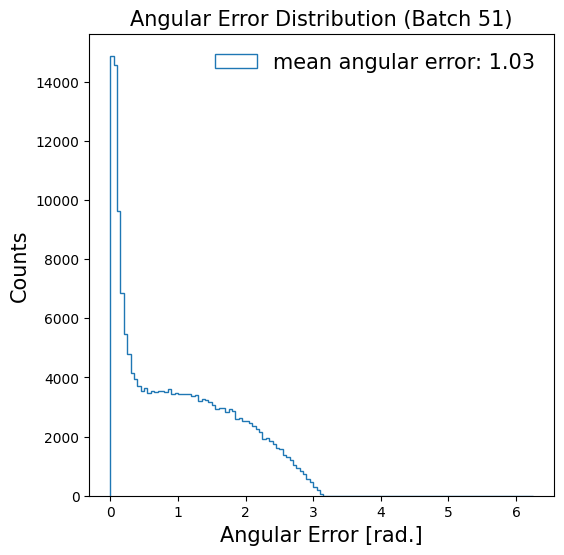

In [13]:
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'mean angular error: {np.round(result["angular_error"].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

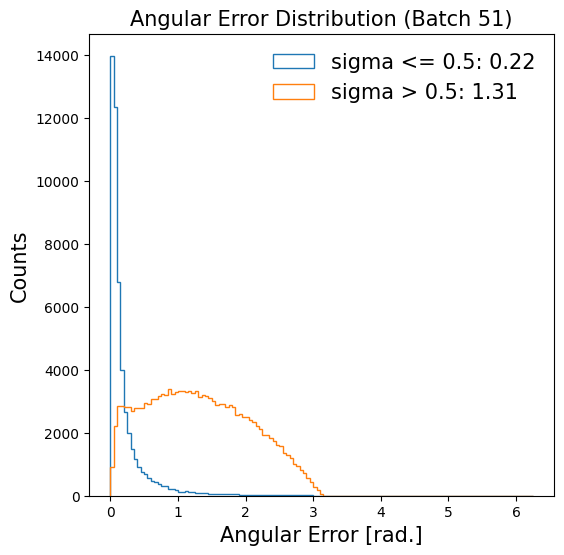

In [14]:
cut_threshold = 0.5
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) <= cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma <= {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) <= cut_threshold].mean(),2)}')

    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) > cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma > {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) > cut_threshold].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!